# Model Free Learning

So this next set of exercises will be completely stolen from David Silver [here](https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf). Hey, remember the reason I'm making this set of exercises is because other than this one exercise, no others existed for David Silver's lecture. 



(Taken from David Silver)

The goal of this assignment is to apply reinforcement learning methods to a simple card game that we call Easy21. This exercise is similar to the Blackjack example in Sutton and Barto 5.3 – please note, however, that the rules of the card game are different and non-standard.

- The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)
- Each draw from the deck results in a value between 1 and 10 (uniformly distributed) with a colour of red (probability 1/3) or black (probability 2/3).
- There are no aces or picture (face) cards in this game
- At the start of the game both the player and the dealer draw one black card (fully observed)
- Each turn the player may either stick or hit
- If the player hits then she draws another card from the deck
- If the player sticks she receives no further cards
- The values of the player’s cards are added (black cards) or subtracted (redcards)
- If  the  player’s  sum  exceeds  21,  or  becomes  less  than  1,  then  she  “goes bust” and loses the game (reward -1)
- If the player sticks then the dealer starts taking turns.  The dealer always sticks on any sum of 17 or greater, and hits otherwise.  If the dealer goes bust,  then  the  player  wins;  otherwise,  the  outcome  –  win  (reward  +1),lose (reward -1), or draw (reward 0) – is the player with the largest sum.

# Exercise 1 -- Implement Easy 21

You should write an environment that implements the game Easy21.  Specifically, write a function, named `step`, which takes as input a state `s` (dealer’s firstcard 1–10 and the player’s sum 1–21), and an action `a` (hit or stick), and returns a sample of the next state `s′` (which may be terminal if the game is finished) and reward `r`.  We will be using this environment for model-free reinforcement learning, and you should not explicitly represent the transition matrix for the MDP. There is no discounting (γ = 1).  You should treat the dealer’s moves as part of the environment, i.e.  calling `step` with a stick action will play out the dealer’s cards and return the final reward and terminal state.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
%matplotlib inline
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation


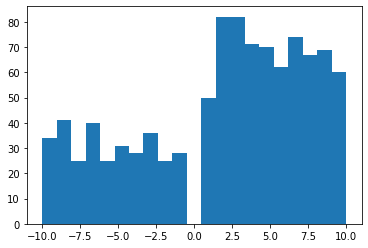

In [2]:

# First I'll just make a function to draw a card
def draw_card(color=None):
    """Draw a card from an infinite deck according to the Easy21 description
    above. 

    Args:
        color (string, optional): A string either `red` or `black` representing
        which color the card is. If `None` then it is drawn randomly according
        to the description above. Defaults to None.

    Returns:
        int: Card value (negative is red, positive is black)
    """
    card = np.random.randint(1, 11)

    if (color == "red"):
        color = -1
    if (color == "black"):
        color = 1
    if (color is None):
        color = np.random.choice([1,1,-1])

    return card * color

# Then just verify it's working nicely
card_samples = []
for i in range(1000):
    card_samples.append(draw_card())

plt.hist(card_samples, bins = 21)
plt.show()

In [3]:
def step(state, action):
    """Moves the environment one time step. This plays out the game of Easy21
    and makes 

    Args:
        state (tuple(int, int)): State tuple representing (dealer_card, player_sum)
        action (boolean): If `True` then the player hits, if `False` the player sticks.
    
    Returns:
        tuple(state, int, bool): A tuple of (state, reward, is_terminal) which indicates
            the resulting state after the time step, the player's sum, and a boolean
            value which is `True` if the state is terminal. 
    """
    dealer_card, player_sum = state
    if action:
        player_card = draw_card()
        player_sum += player_card
        if (player_sum > 21) or (player_sum < 1):
            return [(dealer_card, player_sum), -1, True]
        else:
            return [(dealer_card, player_sum), 0, False]
    else:
        dealer_sum = dealer_card
        while ((dealer_sum < 17) and (dealer_sum > 0)):
            # Draw cards until condition is met.
            dealer_sum += draw_card()
        # Calculate reward
        if ((dealer_sum > 21) or (dealer_sum < 1)):
            return [(dealer_card, player_sum), 1, True]
        elif (dealer_sum > player_sum):
            return [(dealer_card, player_sum), -1, True]
        elif (dealer_sum == player_sum):
            return [(dealer_card, player_sum), 0, True]
        elif (dealer_sum < player_sum):
            return [(dealer_card, player_sum), 1, True]

s_prime, r, term = step((5, 18), False)
print(s_prime, r, term)

(5, 18) -1 True


# Exercise 2 -- Monte-Carlo Control in Easy21

Apply Monte-Carlo control to Easy21.  Initialise the value function to zero. Use a time-varying scalar step-size of `α_t = 1/N(s_t, a_t)` and an ε-greedy exploration strategy with `ε_t = N_0/(N_0+N(s_t))`,  where `N_0 = 100` is a constant, `N(s)` is the number of times that states has been visited, and `N(s,a)` is the number of times that action `a` has been selected from states.  Feel free to choose an alternative value for N0, if it helps producing better results. Plot the optimal value function `V∗(s) = maxaQ∗(s,a)` using similar axes to the following figure taken from Sutton and Barto’s Blackjack example.

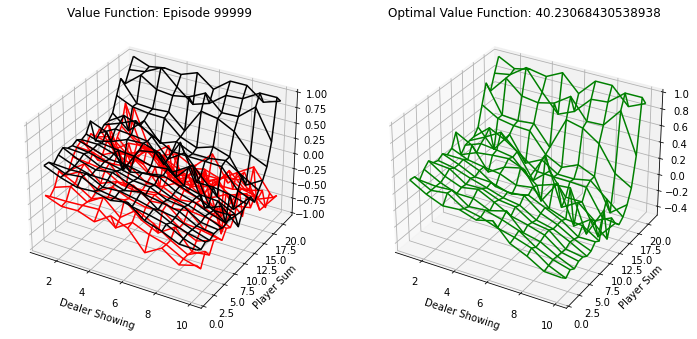

In [4]:
# Yes this is hard coded. 
dealer_cards = 10
player_sum_values = 21
actions = 2


# Convenience function to convert a state into the policy space to get an action
def get_action(Q, state, N, N0=100):
    epsilon = N0/(N0 + np.sum(N[state[0]-1, state[1]-1, :]))
    action_values = Q[state[0] - 1, state[1] - 1, :]
    # If the values are equal, choose an action randomly
    if (action_values[0] == action_values[1]):
        return np.random.uniform() > 0.5
    else:
        greedy_action_idx = np.argmax(Q[state[0] - 1, state[1] - 1, :])

        if epsilon > np.random.uniform():
            return np.random.uniform() > 0.5
        else:
            return greedy_action_idx

# I'm going to make an episode function that returns the result of an episode.
def run_episode(Q, N):
    player_card = draw_card("black")
    dealer_card = draw_card("black")
    s = (dealer_card, player_card)
    states = [] # Initialize the list of states for the episode
    actions = []
    G = 0 # Total return (we don't care about incremental return for monte carlo)

    # Run until terminal state is reached
    while True:
        a = get_action(Q, s, N)
        actions.append(a)
        states.append(s)
        s_prime, r, term = step(s, a)
        
        G += r
        s = s_prime
        if term:
            break
    return (G, states, actions)

def update_action_value_function(states, actions, G, Q, N):
    for s, a in zip(states, actions):
        # Every visit increment
        dci, psi, ai = [s[0]-1, s[1] -1, int(a)] # Dealer card index, player sum index, action index
        N[dci, psi, ai] += 1
        Q[dci, psi, ai] += 1/N[dci, psi, ai]*(G - Q[dci, psi, ai])
    return (N, Q)

def plot_action_value_function(Q):
    xv, yv = np.meshgrid(np.arange(1, Q.shape[0]+1), np.arange(1, Q.shape[1]+1), sparse=False, indexing='ij')
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_wireframe(xv, yv, np.max(Q, axis=2), color='black')
    ax.set_title('wireframe')
    plt.show()

def animate_plot_action_value_function(Qs, episode_nums=None):
    xv, yv = np.meshgrid(np.arange(1, Qs[0].shape[0]+1), np.arange(1, Qs[0].shape[1]+1), sparse=False, indexing='ij')
    fig = plt.figure(figsize=(12, 6))
    # ax = plt.axes(projection='3d')
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    ax1.plot_wireframe(xv, yv, Qs[0][:,:,0], color='black') # Stick
    ax1.plot_wireframe(xv, yv, Qs[0][:,:,1], color="red") # Hit
    
    ax2.plot_wireframe(xv, yv, np.max(Qs[0], axis=2), color="green")
    def draw_plt(iteration):
        ax1.cla()
        ax2.cla()
        ax1.plot_wireframe(xv, yv, Qs[iteration][:,:,0], color='black')
        ax1.plot_wireframe(xv, yv, Qs[iteration][:,:,1], color="red")
        ax2.plot_wireframe(xv, yv, np.max(Qs[iteration], axis=2), color="green")
        episode_str = ""
        if episode_nums:
            episode_str = ": Episode {}".format(episode_nums[iteration])
        ax1.set_title('Value Function' + episode_str)
        ax1.set_xlabel('Dealer Showing')
        ax1.set_ylabel("Player Sum")
        ax2.set_title("Optimal Value Function: {}".format(np.sum(np.max(Qs[iteration], axis=2))) )
        ax2.set_xlabel('Dealer Showing')
        ax2.set_ylabel("Player Sum")

    ani = mpl.animation.FuncAnimation(fig, draw_plt, frames=len(Qs))
    return ani

def evaluate_policy_monte_carlo(episodes, Q, frames=50):
    N = np.zeros_like(Q)     # The number of times each state action pair has been visited

    Qs = []
    episode_nums = []
    key_frames = np.logspace(0, np.log10(episodes), frames, dtype=int)
    for i in range(episodes):
        G, states, actions = run_episode(Q, N)
        N, Q = update_action_value_function(states, actions, G, Q, N)
        if ((i in key_frames) or (i == episodes - 1)):
            episode_nums.append(i)
            Qs.append(np.copy(Q))

    return (Q, animate_plot_action_value_function(Qs, episode_nums))

def iterative_policy_improvement():
    Q = np.zeros((dealer_cards, player_sum_values, actions))  # Action Value function
    Q, ani = evaluate_policy_monte_carlo(100000, Q, 10)
    return Q, ani

Q, ani = iterative_policy_improvement()
ani

# Q = np.zeros((dealer_cards, player_sum_values, actions))
# N = np.zeros_like(Q)
# print(run_episode(N, Q))

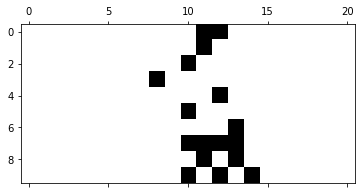

In [5]:
plt.spy(np.argmax(Q, axis=2))


In [6]:
print(np.argmax(Q, axis=2))

[[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0]]


# Exercise 3 -- Sarsa Lambda Control

Implement Sarsa(λ) in Easy21.  Initialise the value function to zero. Use the same step-size and exploration schedules as in the previous section. Run the algorithm with parameter values `λ ∈ {0, 0.1, 0.2,..., 1}`. Stop each run after 1000 episodes and report the mean-squared error `∑s,a(Q(s,a)−Q∗(s,a))^2` over all statessand  actions `a`,  comparing  the  true values `Q∗(s,a)` computed  in  the  previous section with the estimated values `Q(s,a)` computed by Sarsa. Plot the mean-squared error against λ.  For `λ = 0` and `λ = 1` only, plot the learning curve of mean-squared error against episode number.

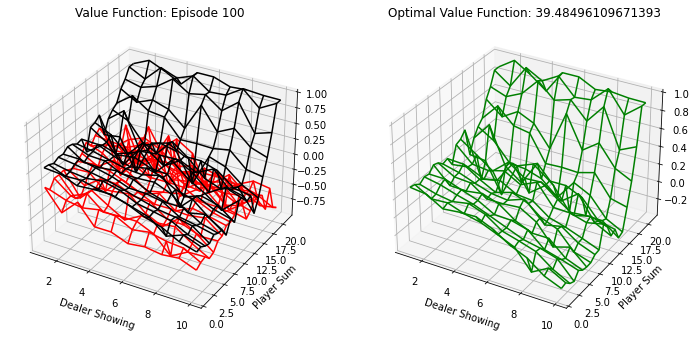

In [13]:

def sarsa_lambda(episodes, lamda=0.9, gamma=1, Q_comp=None):
    Q = np.zeros((dealer_cards, player_sum_values, actions))
    N = np.zeros_like(Q)
    mse = []
    for i in range(episodes):
        if (Q_comp is not None):
            mse.append(np.sum((Q - Q_comp)**2))
        # Eligibility trace
        E = np.zeros_like(Q)
        # Initialise s
        player_card = draw_card("black")
        dealer_card = draw_card("black")
        s = (dealer_card, player_card)
        # Initialise a
        a = get_action(Q, s, N)
        N[s[0]-1, s[1]-1, int(a)] += 1
        # Repeat for each step in the episode
        while True:
            s_prime, r, term = step(s, a)
            
            # Look into the future...
            if term:
                delta = r - gamma * Q[s[0]-1, s[1]-1, int(a)]
            else:
                a_prime = get_action(Q, s_prime, N)
                delta = r + gamma*Q[s_prime[0]-1, s_prime[1]-1, int(a_prime)] -  Q[s[0]-1, s[1]-1, int(a)]
            E[s[0]-1, s[1]-1, int(a)] += 1
            
            # When divided by 0, make 0
            alpha = np.divide(np.ones_like(N), N,out=np.zeros_like(N), where=N!=0)
            Q += alpha * delta * E 
            E = gamma * lamda * E

            N[s[0]-1, s[1]-1, int(a)] += 1
            if term:
                break
            
            s = s_prime
            a = a_prime
    return Q, mse


Q_sarsa, mse  = sarsa_lambda(100000, Q_comp=Q)
animate_plot_action_value_function([Q_sarsa], [100])


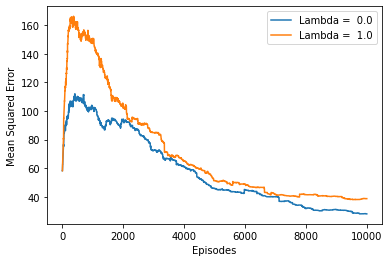

In [30]:
for lamda in np.linspace(0,1, 2):
    _, mse = sarsa_lambda(10000, lamda=lamda, Q_comp=Q)
    plt.plot(mse, label='Lambda = {:4.1f}'.format(lamda))
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Mean Squared Error")
plt.show()


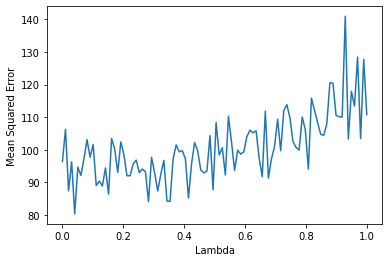

In [29]:
mses = []
lamdas = []
for lamda in np.linspace(0,1, 100):
    _, mse = sarsa_lambda(1500, lamda=lamda, Q_comp=Q)
    mses.append(mse[-1])
    lamdas.append(lamda)

plt.plot(lamdas, mses)
plt.xlabel("Lambda")
plt.ylabel("Mean Squared Error")
plt.show()
